使用minimize求难度及能力时，初始值改为随机，发现题目数量小于100时误差较大。即使初始值为真值，误差仍在0.6左右。模型改为一维，误差降为0.2.说明模型本身误差较大。

In [73]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)
import pymc
import scipy.stats as stats
from scipy.optimize import minimize, rosen, rosen_der

In [321]:
def min_thete_b(y,w,a):
    start1 = y.shape[0]
    start2 = y.shape[0]*2
    start3 = y.shape[0]*2+y.shape[1]
    bnds = ((-3, 3), (-3, 3))*(sum(y.shape))
    def f(x):
        t1 = np.array(x[:start1]).reshape(y.shape[0],1)
        b1 = np.array([[x[start2:start3]]])
        t2 = np.array(x[start1:start2]).reshape(y.shape[0],1)
        b2 = np.array([[-6]*y.shape[1]])
        p1 = (1./(1+ np.exp(-(t1-b1)))).reshape(y.shape)
        p2 = (1./(1+ np.exp(-(t2-b2)))).reshape(y.shape)
        f1 = -(y*(np.log(p1)+np.log(p2))+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]+w*((np.array([x])**2).sum())
        ft1 = -((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[:start1])
        ft2 = -((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[start1:start2])
        fb1 = ((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=0)/y.shape[1]+2*w*np.array(x[start2:start3])
        fb2 = ((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=0)/y.shape[1]+2*w*np.array(x[start3:])
        
        f2 = np.concatenate((ft1,ft2,fb1,fb2))
        return f1,f2
    res = minimize(f, a, bounds=bnds, method='L-BFGS-B',jac=True,options={"disp":True,"gtol":1e-40,"ftol":1e-40})
    min_t1 = np.array(res.x[:start1]).reshape(y.shape[0],1)
    min_b1 = np.array([[res.x[start2:start3]]])
    min_t2 = np.array(res.x[start1:start2]).reshape(y.shape[0],1)
    min_b2 = np.array([[-6]*y.shape[1]])
    return min_t1,min_t2,min_b1,min_b2,res.fun 

In [326]:
def min_thete_b6(y,w,a):
    start1 = y.shape[0]
    start2 = y.shape[0]*2
    start3 = y.shape[0]*2+y.shape[1]
    bnds = ((-3, 3), (-3, 3))*(sum(y.shape))
    def f(x):
        t1 = np.array(x[:start1]).reshape(y.shape[0],1)
        b1 = np.array([[x[start2:start3]]])
        t2 = np.array(x[start1:start2]).reshape(y.shape[0],1)
        b2 = np.array([[-6]*y.shape[1]])
        p1 = (1./(1+ np.exp(-(t1-b1)))).reshape(y.shape)
        p2 = (1./(1+ np.exp(-(t2-b2)))).reshape(y.shape)
        f1 = -(y*(np.log(p1)+np.log(p2))+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]+w*((np.array([x])**2).sum())
        ft1 = -((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[:start1])
        ft2 = -((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[start1:start2])
        fb1 = ((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=0)/y.shape[1]+2*w*np.array(x[start2:start3])       
        f2 = np.concatenate((ft1,ft2,fb1))
        return f1,f2
    res = minimize(f, a, method='BFGS',jac=True,options={"disp":True})
    min_t1 = np.array(res.x[:start1]).reshape(y.shape[0],1)
    min_b1 = np.array([[res.x[start2:start3]]])
    min_t2 = np.array(res.x[start1:start2]).reshape(y.shape[0],1)
    min_b2 = np.array([[-6]*y.shape[1]])
    print res
    return min_t1,min_t2,min_b1,min_b2,res.fun 

In [342]:
n_items=100
n_stu=100
real_b1 = np.random.normal(0,1,(1,n_items))
real_t1 = np.random.normal(0,1,(n_stu,1))
real_b2 = np.random.normal(0,1,(1,n_items))
real_t2 = np.random.normal(0,1,(n_stu,1))
real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
real_p = real_p1*real_p2
uv=np.random.random((n_stu,n_items))<real_p1*real_p2
w = 0.01
n1=0
n2=1

In [343]:
# a = np.random.normal(n1, n2, 2*sum(uv.shape))
a = np.concatenate((real_t1.flat,real_t2.flat,real_b1.flat,real_b2.flat))
min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)

         Current function value: 47.950282
         Iterations: 42
         Function evaluations: 120
         Gradient evaluations: 108


In [344]:
min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
min_p = min_p1*min_p2
print absm(real_p,min_p)
print (absm(real_p1,min_p1)+absm(real_p2,min_p2))/2
print absm(real_t1,min_t1)

0.103841003739
0.201671698188
0.678780090695


In [345]:
real_f1 = -(uv*(np.log(real_p1)+np.log(real_p2))+(1-uv)*np.log(1-real_p1*real_p2)).sum()/uv.shape[1]+w*((np.array([a])**2).sum())

In [346]:
print real_f1

50.0959406514


b2均设为-6，使二维退化为一维

In [330]:
n_items=100
n_stu=100
real_b1 = np.random.normal(0,1,(1,n_items))
real_t1 = np.random.normal(0,1,(n_stu,1))
real_b2 = np.array([[-6]*n_stu])
real_t2 = np.random.normal(0,1,(n_stu,1))
real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
real_p = real_p1*real_p2
uv=np.random.random((n_stu,n_items))<real_p1*real_p2
w = 0.01
n1=0
n2=1

In [331]:
a = np.random.normal(n1, n2, sum(uv.shape)+uv.shape[0])
min_t1,min_t2,min_b1,min_b2,cost = min_thete_b6(uv,w,a)

Optimization terminated successfully.
         Current function value: 55.813613
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41
      fun: 55.81361281144219
 hess_inv: array([[  1.3452e+00,   3.5204e-02,   1.8546e-02, ...,  -3.0028e-03,
          3.5175e-02,   3.1979e-02],
       [  3.5204e-02,   1.0733e+00,   1.9356e-02, ...,   7.6420e-04,
          7.8890e-03,  -7.9843e-03],
       [  1.8546e-02,   1.9356e-02,   1.0219e+00, ...,   6.1991e-03,
          5.7620e-03,   1.3075e-02],
       ..., 
       [ -3.0028e-03,   7.6420e-04,   6.1991e-03, ...,   1.0815e+00,
         -3.3201e-02,  -2.6287e-02],
       [  3.5175e-02,   7.8890e-03,   5.7620e-03, ...,  -3.3201e-02,
          1.0643e+00,   6.4317e-02],
       [  3.1979e-02,  -7.9843e-03,   1.3075e-02, ...,  -2.6287e-02,
          6.4317e-02,   1.0887e+00]])
      jac: array([ -2.7328e-06,   9.4235e-07,   5.7365e-07,   9.1451e-07,
         6.5148e-07,   1.0730e-06,   6.0429e-09,  -8.4964e-07,


In [332]:
min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
min_p = min_p1*min_p2
print absm(real_p,min_p)
print (absm(real_p1,min_p1)+absm(real_p2,min_p2))/2
print absm(real_t1,min_t1)

0.0473600173291
0.0251211628832
0.203784695984


一维误差很低

In [185]:
def min_thete(y,w,b1,b2):
    start1 = y.shape[0]
    a = np.array([1]*2*(y.shape[0]))
    bnds = ((-3, 3), (-3, 3))*(y.shape[0])
    def f(x):
        t1 = np.array(x[:start1]).reshape(y.shape[0],1)
        t2 = np.array(x[start1:]).reshape(y.shape[0],1)
        p1 = (1./(1+ np.exp(-(t1-b1)))).reshape(y.shape)
        p2 = (1./(1+ np.exp(-(t2-b2)))).reshape(y.shape)
        f1 = -(y*np.log(p1*p2)+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]+w*((np.array([x])**2).sum())
        ft1 = -((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[:start1])
        ft2 = -((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[start1:])
        f2 = np.concatenate((ft1,ft2))
        return f1, f2
    res = minimize(f, (a), bounds=bnds,method='L-BFGS-B',jac=True)
    min_t1 = np.array(res.x[:start1]).reshape(y.shape[0],1)
    min_t2 = np.array(res.x[start1:]).reshape(y.shape[0],1)
    return min_t1, min_t2   

In [186]:
n_items=2000
n_stu=100
real_b1 = np.random.normal(0,1,(1,n_items))
real_t1 = np.random.normal(0,1,(n_stu,1))
real_b2 = np.random.normal(0,1,(1,n_items))
real_t2 = np.random.normal(0,1,(n_stu,1))
uv=np.random.random((n_stu,n_items))<1.0/ (1.0 + np.exp(-(real_t1-real_b1)))/ (1.0 + np.exp(-(real_t2-real_b2)))
def absm(a,b):
    return np.abs(a-b).mean()

In [ ]:
n_stu=100
real_b1 = np.random.normal(0,1,(1,n_items))
real_t1 = np.random.normal(0,1,(n_stu,1))
real_b2 = np.random.normal(0,1,(1,n_items))
real_t2 = np.random.normal(0,1,(n_stu,1))
real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
real_p = real_p1*real_p2
uv=np.random.random((n_stu,n_items))<real_p1*real_p2
#     for w in [0.000001,0.00001,0.0001,0.001,0.01,0.1,1]:
    for w in [0.01]:
        for n1 in [-3,-2,-1,0,1,2,3]:
            for n2 in [0.1,1,10]:
                a = np.random.normal(n1, n2, 2*(sum(uv.shape)))
                min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
                print cost
            a = np.array([n1]*2*(sum(uv.shape)))
            min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
            print cost

In [303]:
for n_items in [100]:
    print "-----"+str(n_items)+"----"
    n_stu=100
    real_b1 = np.random.normal(0,1,(1,n_items))
    real_t1 = np.random.normal(0,1,(n_stu,1))
    real_b2 = np.random.normal(0,1,(1,n_items))
    real_t2 = np.random.normal(0,1,(n_stu,1))
    real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
    real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
    real_p = real_p1*real_p2
    uv=np.random.random((n_stu,n_items))<real_p1*real_p2
#     for w in [0.000001,0.00001,0.0001,0.001,0.01,0.1,1]:
    for w in [0.01]:
        for n1 in [-3,-2,-1,0,1,2,3]:
            for n2 in [0.1,1,10]:
                a = np.random.normal(n1, n2, 2*(sum(uv.shape)))
                min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
                print cost
            a = np.array([n1]*2*(sum(uv.shape)))
            min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
            print cost

-----100----
45.2776066914
45.2776066914
nan
45.3085400216


C:\Program1\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: divide by zero encountered in log
C:\Program1\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
C:\Program1\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Program1\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Program1\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


45.2776066914
45.2776066914
45.2776066914
45.3085400216
45.2776066914
45.2776066914
45.2776066914
45.3085400216
45.2776066914
45.2776066914
45.2776066914
45.3085400216
45.2776066914
45.2776066914
nan
45.3085400216
45.2776066914
45.2776066914
45.2776066914
45.3085400216
45.2776066914
45.2776066914
45.2776066914
45.3085400216


初始值对似然无影响，说明已取到极大似然

In [ ]:
for n_items in [100]:
    print "-----"+str(n_items)+"----"
    n_stu=100
    real_b1 = np.random.normal(0,1,(1,n_items))
    real_t1 = np.random.normal(0,1,(n_stu,1))
    real_b2 = np.random.normal(0,1,(1,n_items))
    real_t2 = np.random.normal(0,1,(n_stu,1))
    real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
    real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
    real_p = real_p1*real_p2
    uv=np.random.random((n_stu,n_items))<real_p1*real_p2
#     for w in [0.000001,0.00001,0.0001,0.001,0.01,0.1,1]:
    for w in [0.01]:
        for n1 in [-3,-2,-1,0,1,2,3]:
            for n2 in [0.1,1,10]:
                a = np.random.normal(n1, n2, 2*(sum(uv.shape)))
                min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
                min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
                min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
                min_p = min_p1*min_p2
                print absm(real_p,min_p)
            a = np.array([n1]*2*(sum(uv.shape)))
            min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
            min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
            min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
            min_p = min_p1*min_p2
            print absm(real_p,min_p),n1
                

p误差在0.07以下,初始值对p影响不大,是否和分布有关，固定值比随机更好.题目数量越大，初始值影响越小.题目数量越小，初始值影响越大

In [299]:
for n_items in [100]:
    print "-----"+str(n_items)+"----"
    n_stu=100
    real_b1 = np.random.normal(0,1,(1,n_items))
    real_t1 = np.random.normal(0,1,(n_stu,1))
    real_b2 = np.random.normal(0,1,(1,n_items))
    real_t2 = np.random.normal(0,1,(n_stu,1))
    real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
    real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
    real_p = real_p1*real_p2
    uv=np.random.random((n_stu,n_items))<real_p1*real_p2
#     for w in [0.000001,0.00001,0.0001,0.001,0.01,0.1,1]:
    for w in [0.01]:
        for n1 in [-3,-2,-1,0,1,2,3]:
            for n2 in [0.1,1,10]:
                a = np.random.normal(n1, n2, 2*(sum(uv.shape)))
                min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
                min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
                min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
                print (absm(real_p1,min_p1)+absm(real_p2,min_p2))/2
            a = np.array([n1]*2*(sum(uv.shape)))
            min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
            min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
            min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
            print (absm(real_p1,min_p1)+absm(real_p2,min_p2))/2,n

-----100----
0.144526716602
0.144526711128
0.130161146464
0.128495961363 4
0.130161138255
0.144526693328
0.144526713568
0.128495962045 4
0.130161142511
0.14452669693
0.130161131389
0.128495961858 4
0.130161139226
0.130161140811
0.144526698893
0.12849596186 4
0.14452670768
0.13016114459
0.144526691436
0.128495961862 4
0.130161149246
0.144526699478
0.130161144609
0.128495961612 4
0.144526707333
0.144526714628
0.130161134778
0.128495961632 4


p1,p2误差在0.12-0.16,影响不大.题目数量越大，初始值影响越小.题目数量越小，初始值影响越大

AttributeError: 'tuple' object has no attribute 'show'

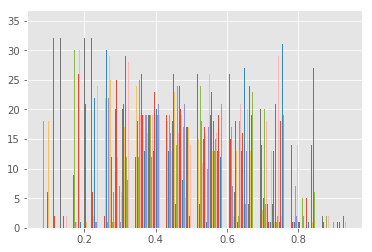

In [268]:
plt.hist(min_p1).show()

In [300]:
for n_items in [100]:
    print "-----"+str(n_items)+"----"
    n_stu=100
    real_b1 = np.random.normal(0,1,(1,n_items))
    real_t1 = np.random.normal(0,1,(n_stu,1))
    real_b2 = np.random.normal(0,1,(1,n_items))
    real_t2 = np.random.normal(0,1,(n_stu,1))
    real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
    real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
    real_p = real_p1*real_p2
    uv=np.random.random((n_stu,n_items))<real_p1*real_p2
#     for w in [0.000001,0.00001,0.0001,0.001,0.01,0.1,1]:
    for w in [0.01]:
        for n1 in [-3,-2,-1,0,1,2,3]:
            for n2 in [0.1,1,10]:
                a = np.random.normal(n1, n2, 2*(sum(uv.shape)))
                min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
                min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
                min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
                print (absm(real_t1-real_b1,min_t1-min_b1)+absm(real_t2-real_b2,min_t2-min_b2))/2
            a = np.array([n1]*2*(sum(uv.shape)))
            min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
            min_p1 = 1.0/ (1.0 + np.exp(-(min_t1-min_b1))).reshape(uv.shape)
            min_p2 = 1.0/ (1.0 + np.exp(-(min_t2-real_b2))).reshape(uv.shape)
            print (absm(real_t1-real_b1,min_t1-min_b1)+absm(real_t2-real_b2,min_t2-min_b2))/2,n1

-----100----
0.769561782449
0.76956171538
1.08577326525
0.891416259731 -3
1.08577324823
0.76956170073
1.08577326259
0.891416260135 -2
1.08577327742
0.769561695273
1.08577325242
0.891416261026 -1
0.769561740551
1.08577323525
0.769561758967
0.891416260452 0
0.769561660348
1.08577329828
1.08577325188
0.891416261026 1
1.08577328265
0.769561721611
1.08577324089
0.891416259914 2
0.769561683487
1.08577327447
1.085773261
0.891416260569 3


t-b误差在0.8-0.9左右，初始值影响不大.题目数量越大，初始值影响越小

In [295]:
for n_items in [100]:
    print "-----"+str(n_items)+"----"
    n_stu=100
    real_b1 = np.random.normal(0,1,(1,n_items))
    real_t1 = np.random.normal(0,1,(n_stu,1))
    real_b2 = np.random.normal(0,1,(1,n_items))
    real_t2 = np.random.normal(0,1,(n_stu,1))
    real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1)))
    real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2)))
    real_p = real_p1*real_p2
    uv=np.random.random((n_stu,n_items))<real_p1*real_p2
    for w in [0.01]:
        for n1 in [-3,-2,-1,0,1,2,3]:
            for n2 in [0.1,1,10]:
                a = np.random.normal(n1, n2, 2*(sum(uv.shape)))
                min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
                print (absm(real_b1,min_b1)+absm(real_b2,min_b2)+absm(real_t1,min_t1)+absm(real_t2,min_t2))/4
            a = np.array([n1]*2*(sum(uv.shape)))
            min_t1,min_t2,min_b1,min_b2,cost = min_thete_b(uv,w,a)
            print (absm(real_b1,min_b1)+absm(real_b2,min_b2)+absm(real_t1,min_t1)+absm(real_t2,min_t2))/4,n1

-----100----
0.76165314559
0.761653185984
0.761653196447
0.656512682687 -3
0.61400837632
0.761653194632
0.614008385831
0.656512682756 -2
0.614008347521
0.761653170944
0.614008420237
0.656512682911 -1
0.614008416264
0.614008407843
0.614008404083
0.656512682941 0
0.761653171211
0.614008425206
0.761653167359
0.65651268289 1
0.7616531368
0.614008416378
0.761653165446
0.65651268258 2
0.761653180364
0.761653217874
0.61400841392
0.656512683091 3


t,b误差在0.6-0.7左右，初始值影响不大.题目数量越大，初始值影响越小

In [104]:
np.array([[1,1],[2,2]])*np.array([[1,1],[2,2]])

array([[1, 1],
       [4, 4]])

In [145]:
x = np.concatenate((real_t1.reshape(n_stu),real_t2.reshape(n_stu),real_b1.reshape(n_items),real_b2.reshape(n_items)))
y = uv
w = 0.01
start1 = y.shape[0]
start2 = y.shape[0]*2
start3 = y.shape[0]*2+y.shape[1]
t1 = np.array(x[:start1]).reshape(y.shape[0],1)
b1 = np.array([[x[start2:start3]]])
t2 = np.array(x[start1:start2]).reshape(y.shape[0],1)
b2 = np.array([[x[start3:]]])
p1 = 1./(1+ np.exp(-(t1-b1))).reshape(100,50)
p2 = 1./(1+ np.exp(-(t2-b2))).reshape(100,50)
f1 = -(y*np.log(p1*p2)+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]+w*((np.array([x])**2).sum())
ft1 = -((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[:start1])
ft2 = -((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[start1:start2])
fb1 = ((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=0)/y.shape[1]+2*w*np.array(x[start2:start3])
fb2 = ((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=0)/y.shape[1]+2*w*np.array(x[start3:])
f2 = np.concatenate((ft1,ft2,fb1,fb2))

In [192]:
np.array([1,2,3]).reshape(-1,1)

array([[1],
       [2],
       [3]])

In [193]:
real_t1.reshape(n_stu)

array([ 0.7044, -1.9106,  1.0013,  0.627 , -0.8164,  0.4819,  1.0721,
        0.9205, -0.1907,  0.1093,  0.6094, -0.7593,  0.1324, -1.8441,
       -0.3716,  0.4098, -0.3475, -0.6369, -0.7117,  0.0792, -0.322 ,
        2.1848, -0.0058, -0.6223,  0.0321, -0.1122, -0.8908, -0.3365,
       -1.1124,  1.2354, -0.2664, -0.1507,  0.7078, -0.9453, -1.1156,
        1.1329,  0.5634, -0.9705,  0.228 ,  0.0315, -1.2903,  1.0516,
        1.1725, -0.1146,  0.7072, -0.5564,  1.5593, -0.9738,  1.3965,
       -1.5915, -1.4378, -0.3122, -1.2419,  1.3278,  0.8942, -0.9207,
       -1.1358,  0.4718, -0.7244,  1.1833,  0.5082, -0.3543, -0.7908,
        0.9566, -1.42  , -0.736 ,  1.2543, -0.5837, -1.5117,  1.0466,
       -1.2752, -1.1805,  0.7367,  0.4302,  1.0047,  1.4533,  1.6236,
       -0.8788,  0.4316,  0.1586, -0.4265, -0.2976, -0.0847,  0.392 ,
        0.6819, -1.1503,  0.6058, -1.2869,  0.576 , -2.7136,  2.5716,
        0.9982,  1.0751,  1.7485, -1.3515,  0.1077,  0.9926, -0.802 ,
        1.0499,  0.1